In [1]:
import pandas as pd
import networkx as nx
from node2vec import Node2Vec
import umap 
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# 1. PRÉPARATION DES DONNÉES
file_nodes = 'NODES_climatoscope_graph_2022-07-01_2022-10-30_th=3.0_flc=0_world_2185-pro-anti_Louvaindic_testtop_tableusers.csv'
df_nodes = pd.read_csv(file_nodes, low_memory=False)

dic_opinions = df_nodes.set_index('Id')['modularity_class'].map(
    lambda x: 'Pro-Climat' if x == 4 else ('Sceptique' if x == 0 else 'Neutre/Autre')
).to_dict()

In [3]:
2986 in df_nodes["Id"].values


False

In [4]:
df_nodes.head

<bound method NDFrame.head of                       Id Label  nb_retweets  nb_retweeted  modularity_class  \
0     961997551015682049   NaN        212.0        3884.0                 4   
1              329294962   NaN        456.0        2689.0                 4   
2    1030824102070808582   NaN      10123.0        9378.0                 4   
3     926309671773683712   NaN        778.0        3076.0                 4   
4               20329672   NaN        142.0        3635.0                 4   
..                   ...   ...          ...           ...               ...   
607             45190383   NaN         41.0         675.0                 0   
608             20076659   NaN          5.0        1014.0                 0   
609            275367178   NaN          2.0         378.0                 0   
610             28614262   NaN         25.0         836.0                 0   
611  1358956387636805634   NaN        138.0         341.0                 0   

     pageranks  Modul

In [5]:

df_nodes["Id"].sort_values().tail(20)


573    1494513441234636815
503    1499860649232551942
507    1504944627522195460
516    1511210025955561479
506    1518027433336737792
498    1518703170700075009
466    1519692789537067008
529    1521329369796558848
497    1524890440952172545
572    1525698192297193472
494    1527223403920232448
574    1531051309671059456
505    1537225604554031104
513    1545523991217147907
602    1547763786559266816
576    1548059402761949185
467    1551015498636070912
472    1552067520575799298
496    1557864522555203590
502    1560341081576939524
Name: Id, dtype: int64

In [8]:
c=set(G.nodes()).intersection(set(df_nodes["Id"].values))
len(c)


398

In [7]:
# 2. CONSTRUCTION DU  GRAPHE :
file_graph = 'graph_2022-01-01_to_2022-01-14.csv' 
df_edges = pd.read_csv(file_graph)

G = nx.from_pandas_edgelist(
    df_edges, 
    source='user_id', 
    target='original_author'
)

In [9]:
df_edges.head

<bound method NDFrame.head of                    user_id      original_author  nb_retweeted
0                     2986            963157886             2
1                     3634            366208117             2
2                    13621               818340             2
3                    48903  1006419421244678144             2
4                    69053            230014111             2
...                    ...                  ...           ...
47192  1481998550330396684  1423033521275351047             3
47193  1481998550330396684  1430496265272451072             3
47194  1482019936939941889            133880286             2
47195  1482040320162508808            192942213             3
47196  1482108641356431362  1203315306933841920             2

[47197 rows x 3 columns]>

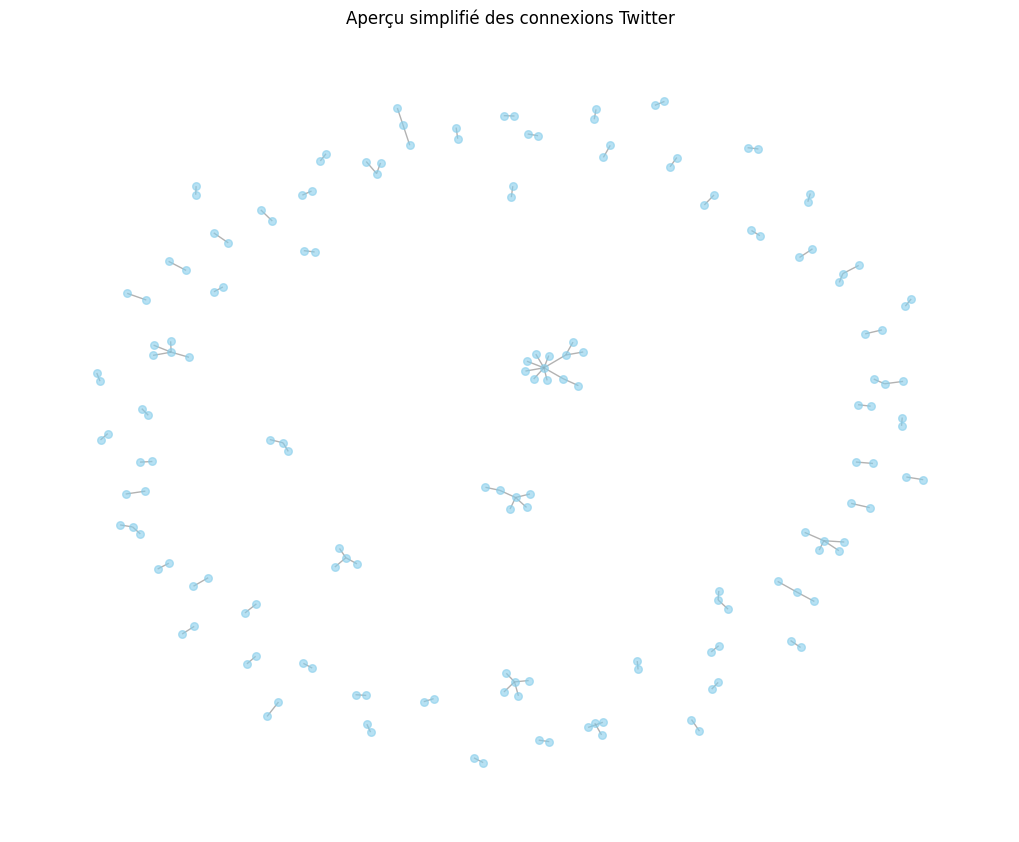

In [10]:
#Dessiner
file_graph = 'graph_2022-01-01_to_2022-01-14.csv' 
df = pd.read_csv(file_graph)

df_petit = df.head(100)

Gr = nx.from_pandas_edgelist(df_petit, source='user_id', target='original_author')

# 4. Dessiner
plt.figure(figsize=(10, 8))
nx.draw(Gr, 
        with_labels=False, 
        node_size=30, 
        node_color="skyblue", 
        edge_color="gray", 
        alpha=0.6)

plt.title("Aperçu simplifié des connexions Twitter")
plt.show()

In [11]:
#NODE2VEC
node2vec = Node2Vec(G, dimensions=32, walk_length=10, num_walks=40, workers=4, quiet=True)
model = node2vec.fit(window=5, min_count=1, batch_words=4)

In [6]:
#RÉDUCTION DE DIMENSION
nodes_list = list(G.nodes())
embeddings = [model.wv[str(n)] for n in nodes_list]

reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42,dim)
umap_results = reducer.fit_transform(embeddings)

/home/bourenane/.local/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


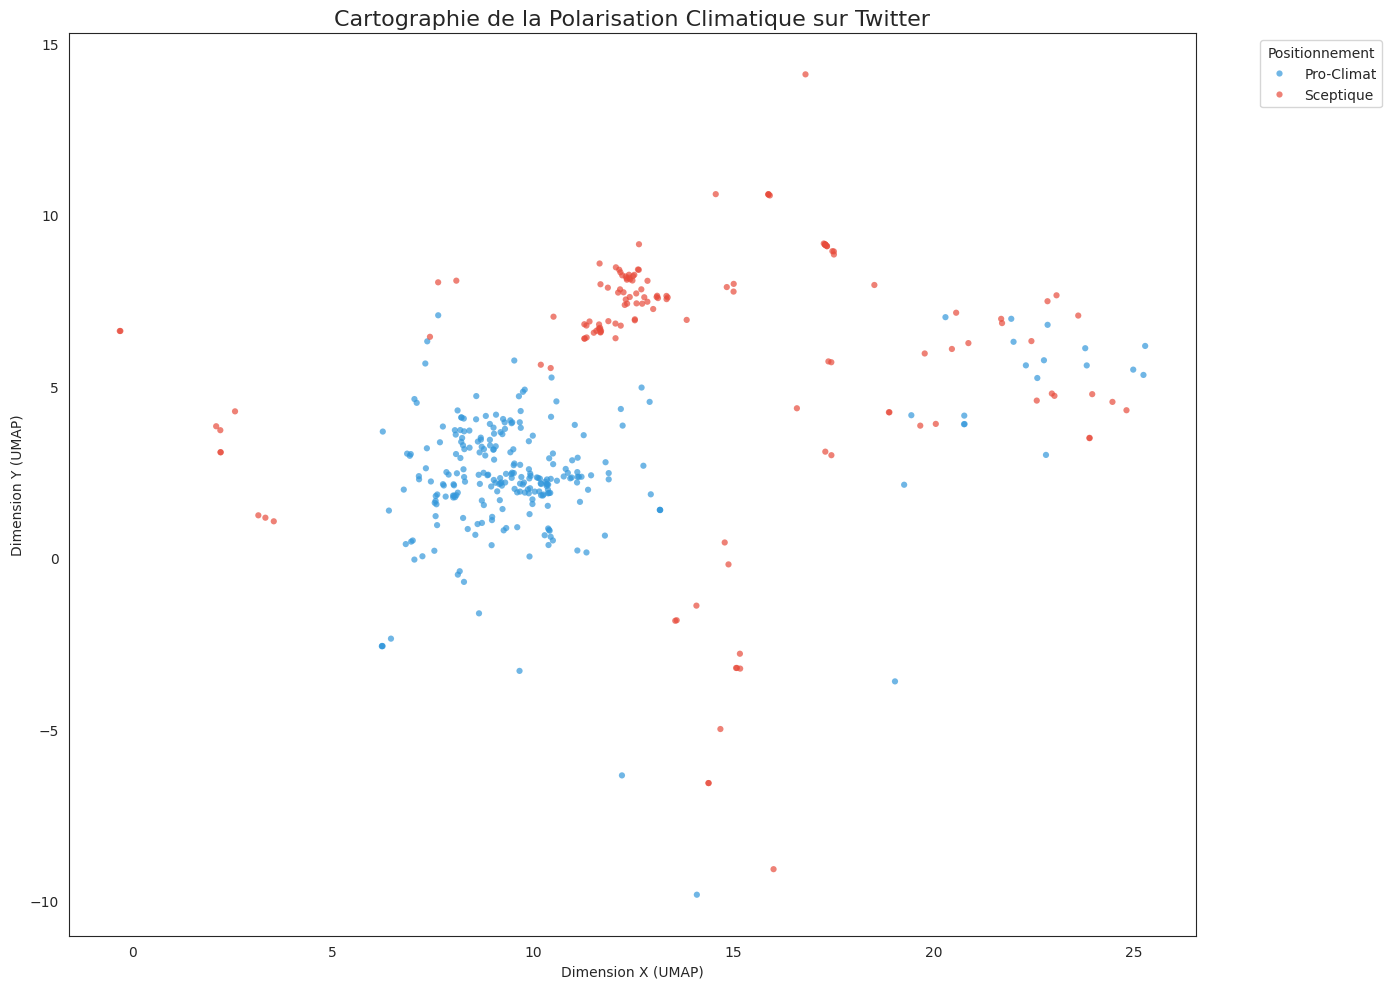

In [63]:
#RENDU VISUEL
df_viz = pd.DataFrame(umap_results, columns=['x', 'y'])
df_viz['Id'] = nodes_list
df_viz['Opinion'] = df_viz['Id'].map(dic_opinions).fillna('Inconnu')
df =df_viz[df_viz['Opinion']!='Inconnu']

plt.figure(figsize=(14, 10))
sns.set_style("white") 

sns.scatterplot(
    data=df, x='x', y='y', hue='Opinion',
    palette={'Pro-Climat': '#3498db', 'Sceptique': '#e74c3c', 'Neutre/Autre': '#95a5a6', 'Inconnu': '#ecf0f1'},
    s=20, alpha=0.7, edgecolor='none'
)

plt.title("Cartographie de la Polarisation Climatique sur Twitter", fontsize=16)
plt.xlabel("Dimension X (UMAP)")
plt.ylabel("Dimension Y (UMAP)")
plt.legend(title="Positionnement", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

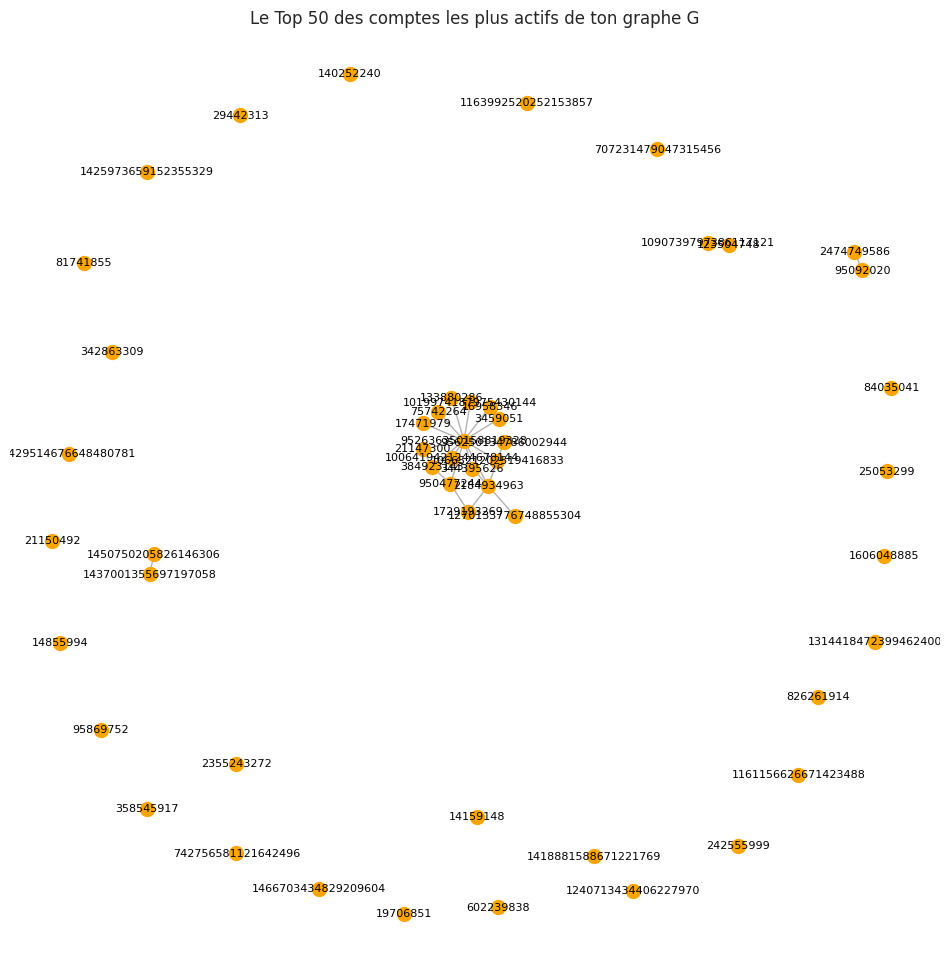

In [8]:


plt.figure(figsize=(12, 12))

# 1. On trouve les 50 personnes les plus connectées (les "Hubs")
# On calcule le "degré" (nombre de liens) de chacun
degrees = dict(G.degree())
# On garde les 50 plus gros
top_nodes = sorted(degrees, key=degrees.get, reverse=True)[:50]

# 2. On crée un mini-graphe avec juste ces gens-là
sub_graph = G.subgraph(top_nodes)

# 3. On dessine !
pos = nx.spring_layout(sub_graph, seed=42) # L'algo qui place les points pour que ce soit joli

nx.draw_networkx_nodes(sub_graph, pos, node_size=100, node_color='orange') # Les points
nx.draw_networkx_edges(sub_graph, pos, alpha=0.3) # Les traits (transparents)
nx.draw_networkx_labels(sub_graph, pos, font_size=8) # Les noms (IDs)

plt.title("Le Top 50 des comptes les plus actifs de ton graphe G")
plt.axis('off') # On enlève les axes x et y qui ne servent à rien ici
plt.show()

In [48]:
# SUPERVISÉ
labels= [dic_opinions.get(node,"Inconnu") for node in list(G.nodes())]


In [14]:
list(dic_opinions.keys())[:5]


[961997551015682049,
 329294962,
 1030824102070808582,
 926309671773683712,
 20329672]

In [47]:
dic_opinions[1006419421244678144]

'Pro-Climat'

In [16]:
list(G.nodes())[:20]


[2986,
 963157886,
 3634,
 366208117,
 13621,
 818340,
 48903,
 1006419421244678144,
 69053,
 230014111,
 718564180094283776,
 476083,
 861474256386875392,
 633973,
 657433,
 380956211,
 685063,
 1717291,
 726393,
 486864604]

In [50]:
!pip install torch torchvision torchaudio

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 915.7/915.7 MB 1.7 MB/s  0:08:37 eta 0:00:010:00:16m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 2.4 MB/s  0:00:05m 2.4 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB 1.6 MB/s  0:05:05 eta 0:00:010:00:09
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 4.4 MB/s  0:00:02m 4.6 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 MB 1.3 MB/s  0:01:05 eta 0:00:010:00:02
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 954.8/954.8 kB 2.3 MB/s  0:00:00m 2.5 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 706.8/706.8 MB 4.0 MB/s  0:04:44 eta 0:00:010:00:04m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 MB 3.9 MB/s  0:00:56 eta 0:00:010:00:02
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 6.1 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.6/63.6 MB 5.2 MB/s  0:00:12 e

In [53]:
import numpy as np
import torch

In [55]:
data=df_viz[df_viz['Opinion'] != 'Inconnu'].copy()
data['Opinion']=data['Opinion'].map( lambda x : 1 if x=='Pro-Climat' else 0) 

In [56]:
print(data['Opinion'].value_counts())

Opinion
1    258
0    140
Name: count, dtype: int64


In [58]:
x_data=np.array([model.wv[str(node)] for node in list(data['Id'])])
y_data=data['Opinion'].values

In [59]:
x_tensor=torch.FloatTensor(x_data)
y_tensor=torch.FloatTensor(y_data).view(-1, 1)

In [60]:
#La structure :
import torch.nn as nn
class ClimateClassifier(nn.Module):
    def __init__(self):
        super(ClimateClassifier, self).__init__()
        # ICI : On change 32 par 10 !
        self.fc1 = nn.Linear(10, 16) 
        
        self.fc2 = nn.Linear(16, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        return x